## task 3

The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.



In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, kurtosis, skew

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.inspection import permutation_importance

In [237]:
credit = pd.read_csv('Task 3 and 4_Loan_Data.csv')
credit.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [238]:
credit.isna().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [239]:
credit.default.value_counts()

default
0    8149
1    1851
Name: count, dtype: int64

In [240]:
credit.credit_lines_outstanding = credit.credit_lines_outstanding.apply(lambda x: str(x))
credit.years_employed = credit.years_employed.apply(lambda x: str(x))
credit.default = credit.default.apply(lambda x: str(x))


## EDA

In [241]:
credit['fico_zscore'] = (credit.fico_score - np.mean(credit.fico_score))/np.std(credit.fico_score)

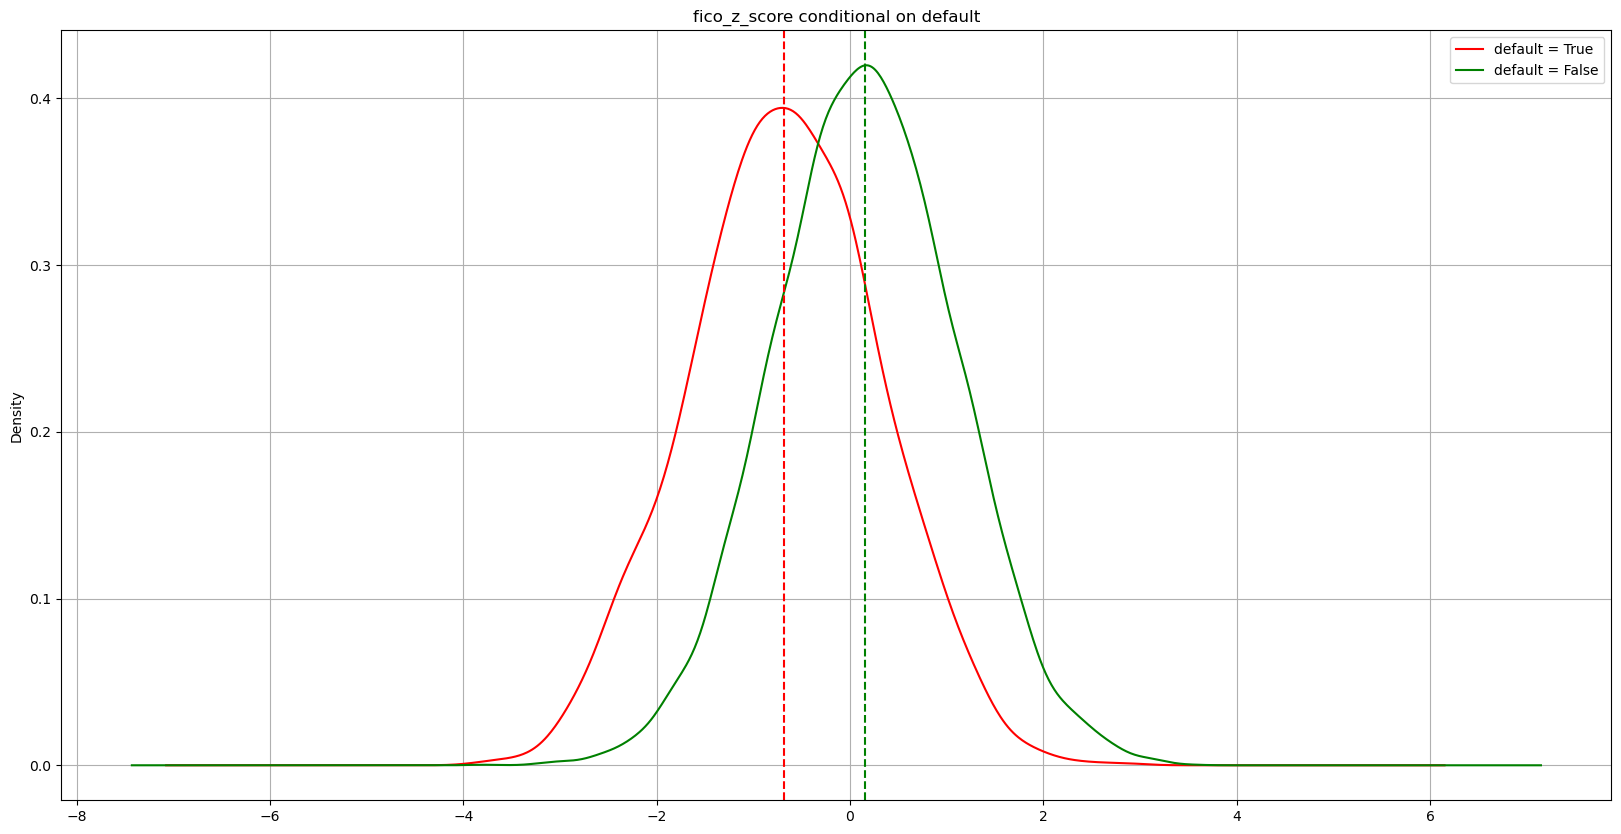

In [242]:
## conditional distribution of ficozscore
fig, ax = plt.subplots(figsize = (20,10))
credit[credit.default == '1']['fico_zscore'].plot.density(ax = ax, color = 'red', label = 'default = True')
credit[credit.default == '0']['fico_zscore'].plot.density(ax = ax, color = 'green', label = 'default = False')
plt.axvline(np.mean(credit[credit.default == '1']['fico_zscore']), color = 'red', linestyle = '--')
# plt.axvline(np.mean(credit[credit.default == 0]['ficozscore']) - np.std(credit[credit.default == 0]['ficozscore']), color = 'black', linestyle = '--')
plt.axvline(np.mean(credit[credit.default == '0']['fico_zscore']), color = 'green', linestyle = '--')
plt.title('fico_z_score conditional on default')
plt.legend()
plt.grid()
plt.show()

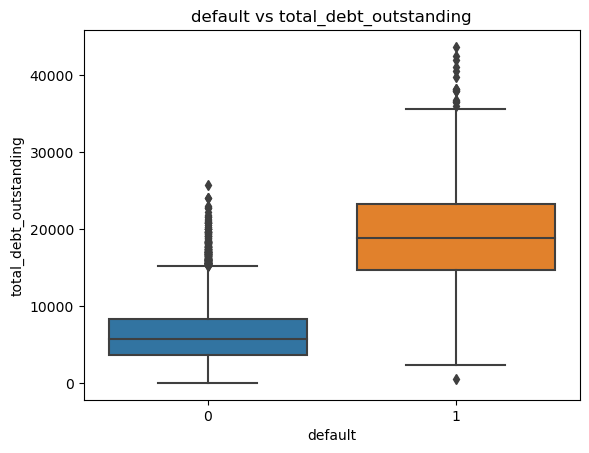

In [243]:
sns.boxplot(x = "default",y = 'total_debt_outstanding', data = credit)
plt.title('default vs total_debt_outstanding')
plt.show()

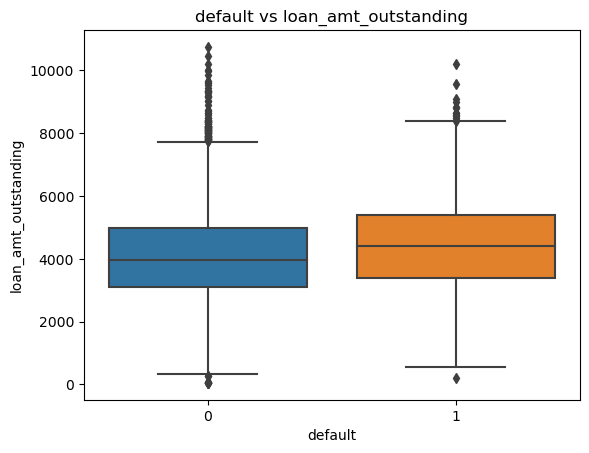

In [244]:
sns.boxplot(x = "default",y = 'loan_amt_outstanding', data = credit)
plt.title('default vs loan_amt_outstanding')
plt.show()

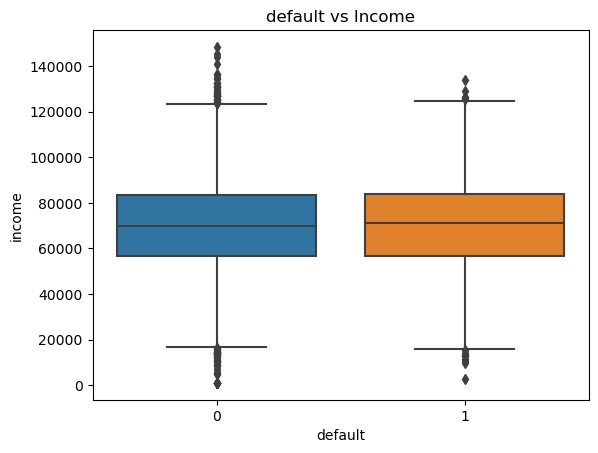

In [245]:
sns.boxplot(x = "default",y =  'income', data = credit)
plt.title('default vs Income')
plt.show()

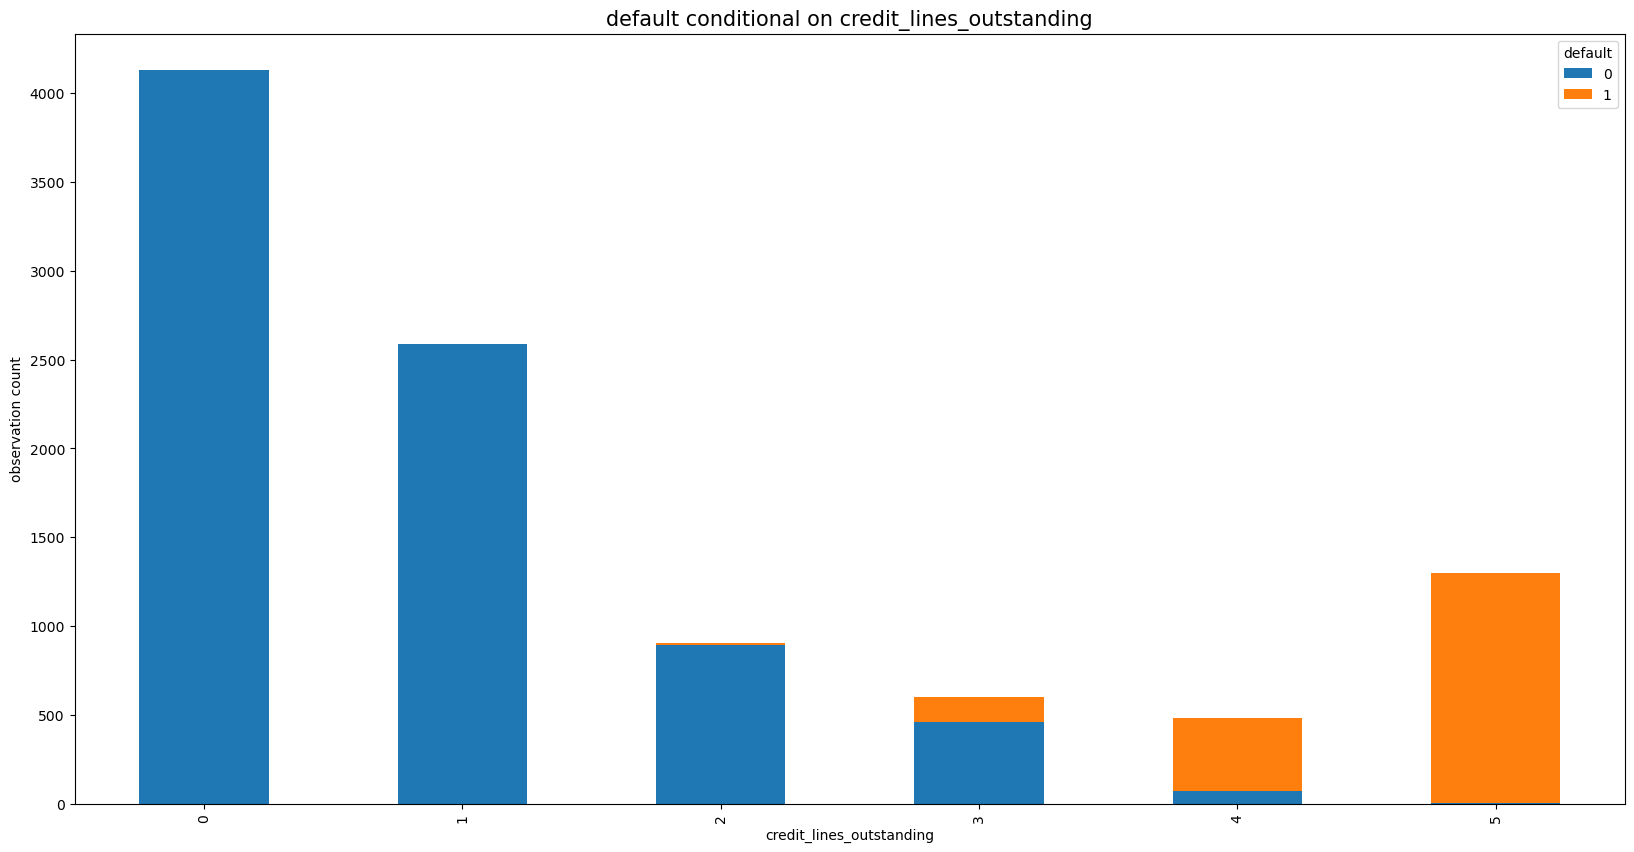

In [246]:
default_credit_outstanding_crosstab=pd.crosstab(index=credit.credit_lines_outstanding, columns=credit.default)
default_credit_outstanding_crosstab.plot(kind='bar', figsize=(20,10), stacked=True)
plt.title('default conditional on credit_lines_outstanding',size = 15)
plt.ylabel('observation count')
plt.show()

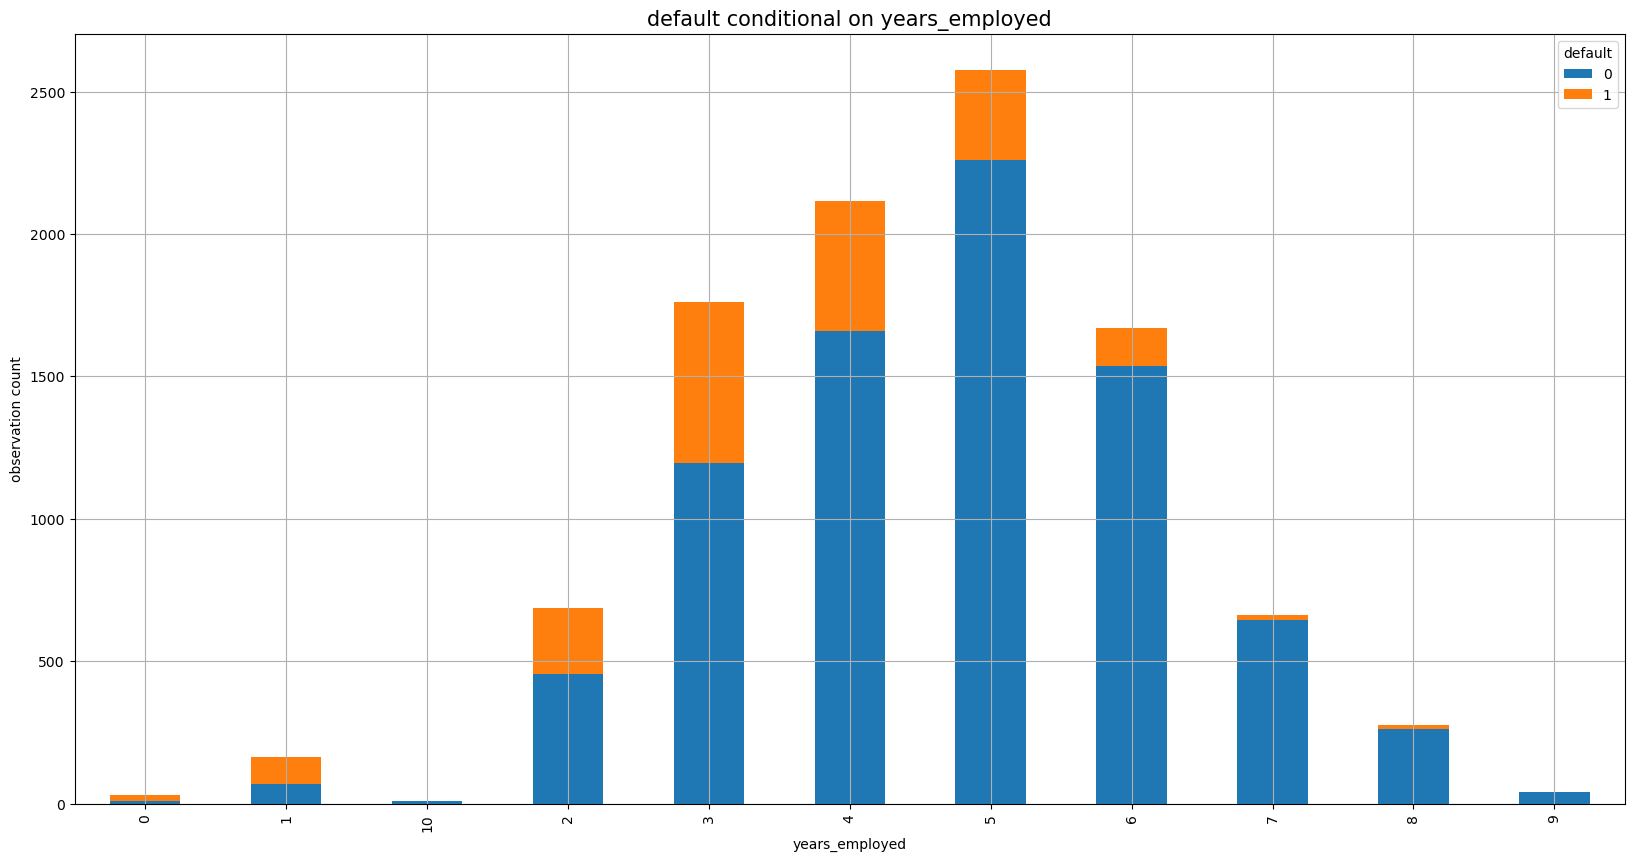

In [247]:
years_employed_crosstab=pd.crosstab(index=credit.years_employed, columns=credit.default)
years_employed_crosstab.plot(kind='bar', figsize=(20,10), stacked=True)
plt.title('default conditional on years_employed',size = 15)
plt.ylabel('observation count')
plt.grid()
plt.show()

In [248]:
credit.loc[:,credit.dtypes != object].corr()

,customer_id,loan_amt_outstanding,total_debt_outstanding,income,fico_score,fico_zscore
customer_id,1.000000,-0.013857,0.003541,-0.008064,0.008044,0.008044
loan_amt_outstanding,-0.013857,1.000000,0.397403,0.835815,-0.031373,-0.031373
total_debt_outstanding,0.003541,0.397403,1.000000,0.394397,-0.232246,-0.232246
income,-0.008064,0.835815,0.394397,1.000000,-0.010528,-0.010528
fico_score,0.008044,-0.031373,-0.232246,-0.010528,1.000000,1.000000
fico_zscore,0.008044,-0.031373,-0.232246,-0.010528,1.000000,1.000000


## preparing data for modelling 

In [249]:
## resetting to oneHotencoding datatype
credit.credit_lines_outstanding = credit.credit_lines_outstanding.apply(lambda x: int(x))
credit.years_employed = credit.years_employed.apply(lambda x: int(x))
credit.default = credit.default.apply(lambda x: int(x))


In [250]:
## splitting into train val test sets
credit.set_index('customer_id', inplace = True)
# features = 
features_continous = credit.loc[:,['loan_amt_outstanding','fico_score', 'total_debt_outstanding','income']].copy()
features_cata = credit.loc[:,['years_employed', 'credit_lines_outstanding']].copy()
features = pd.concat([features_continous, features_cata],axis = 1)
target = credit.loc[:,'default'].copy()
customer_ids = features.index.copy() 
features

,loan_amt_outstanding,fico_score,total_debt_outstanding,income,years_employed,credit_lines_outstanding
customer_id,,,,,,
8153374,5221.545193,605,3915.471226,78039.38546,5,0
7442532,1958.928726,572,8228.752520,26648.43525,2,5
2256073,3363.009259,602,2027.830850,65866.71246,4,0
4885975,4766.648001,612,2501.730397,74356.88347,5,0
4700614,1345.827718,631,1768.826187,23448.32631,6,1
...,...,...,...,...,...,...
3972488,3033.647103,697,2553.733144,42691.62787,5,0
6184073,4146.239304,615,5458.163525,79969.50521,8,1
6694516,3088.223727,596,4813.090925,38192.67591,5,2


In [251]:
## spliting into full_train and test, maintaining the class imbalence in the target variable
X = features.to_numpy()
y =  target.to_numpy()

X_full_train, X_test, y_full_train, y_test, ID_full_train, ID_test = train_test_split(X,y, customer_ids, test_size=0.15,
                                                                                      random_state= 47, stratify=target.to_numpy())
X_train, X_val, y_train, y_val, ID_train, ID_val = train_test_split(X_full_train, y_full_train,
                                                                                ID_full_train, test_size=0.2, random_state= 47, stratify=y_full_train)
print('training shapes: ', X_train.shape, y_train.shape)
print('val shapes     : ', X_val.shape, y_val.shape)
print('testing shapes : ', X_test.shape, y_test.shape)



training shapes:  (6800, 6) (6800,)
val shapes     :  (1700, 6) (1700,)
testing shapes :  (1500, 6) (1500,)


In [252]:
X_full_train_unscaled = X_full_train.copy()
X_test_unscaled = X_test.copy()
x_val_unsaled = X_val.copy()

In [253]:
X_full_train[:,:-2]

array([[ 3097.726306,   746.      ,  5869.772482, 46601.89065 ],
       [ 2596.69212 ,   568.      , 10270.8521  , 55666.05492 ],
       [ 3856.525765,   619.      ,  2329.098179, 56390.06406 ],
       ...,
       [ 4634.22781 ,   597.      ,  5870.038417, 90501.41664 ],
       [ 1172.733329,   722.      ,  1552.614183, 16980.31489 ],
       [ 3401.967412,   571.      ,  4310.060773, 69056.85359 ]])

In [254]:
## we must standardized continous variables for some methods.Standardizing different datasets individually to avoid leakage
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_full_train[:,:-2])
X_full_train[:,:-2] = scaler.transform(X_full_train[:,:-2])
X_train[:,:-2] = scaler.transform(X_train[:,:-2])
X_val[:,:-2] = scaler.transform(X_val[:,:-2])
X_test[:,:-2] = scaler.transform(X_test[:,:-2])

In [255]:
x_full_train_df = pd.DataFrame(X_full_train)
x_full_train_df.mean()

0   -3.198879e-15
1   -5.703673e-16
2    3.206180e-15
3   -5.522241e-16
4    4.546353e+00
5    1.461529e+00
dtype: float64

In [256]:
x_full_train_df.std()

0    1.000059
1    1.000059
2    1.000059
3    1.000059
4    1.565931
5    1.740502
dtype: float64

# begin modelling

- logistic regression : Benchmark model
- regularized logistic regression: tuning
- Random forest

In [257]:
## what if I mark all test results as 0: no default the majority of the class!
sum(y_test == 0)/len(y_test) ## I will be right 81% of times. So any intelligent model will have to be more accurate than 81% to be meaning full. 

0.8146666666666667

In [258]:
## let's begin making models: logistic regression

## logistic regression model with entire standardized training data

logistic = LogisticRegression(penalty=None)
# fit on the entire training set since no need for validation 
logistic.fit(X_full_train, y_full_train)
# predict on test set
yhat_logistic = logistic.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_true=y_test, y_pred =yhat_logistic)
print('Accuracy: %.2f' % (accuracy*100))
print(confusion_matrix(y_true= y_test, y_pred = yhat_logistic))

Accuracy: 99.87
[[1221    1]
 [   1  277]]


In [259]:
logistic_proba = logistic.predict_proba(X_test)


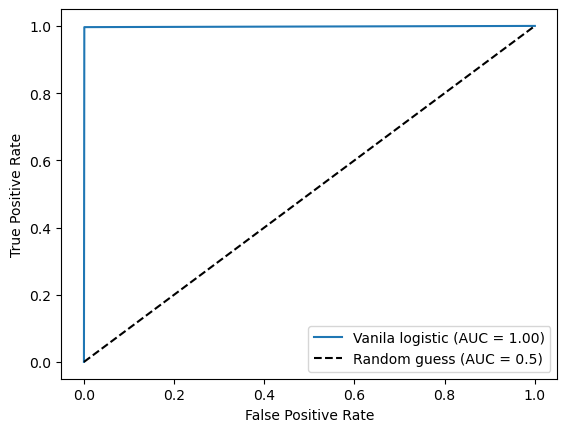

In [260]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat_logistic)

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name ='Vanila logistic')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="Random guess (AUC = 0.5)")
plt.legend()
plt.show()

In [261]:
list_l1_ratio = np.linspace(0.001,1,35) 
## creating a list of alpha values to try out in the val set , 35 evenly spaced numbers between 0 and 1
print(list_l1_ratio)

[0.001      0.03038235 0.05976471 0.08914706 0.11852941 0.14791176
 0.17729412 0.20667647 0.23605882 0.26544118 0.29482353 0.32420588
 0.35358824 0.38297059 0.41235294 0.44173529 0.47111765 0.5005
 0.52988235 0.55926471 0.58864706 0.61802941 0.64741176 0.67679412
 0.70617647 0.73555882 0.76494118 0.79432353 0.82370588 0.85308824
 0.88247059 0.91185294 0.94123529 0.97061765 1.        ]


In [262]:
## individually fitting a model and calculating 'accuracy' on the validation set
list_val_predictions = []
list_accuracy = []
list_estimated_coef = []
for alpha in list_l1_ratio:

    ## DEFINE MODEL
    logistic_lasso = LogisticRegression(penalty = 'l2', C = alpha, solver = 'lbfgs')

    logistic_lasso.fit(X_train, y_train)
    ## not training on the full training set this time
    yhat_logistic_lasso = logistic_lasso.predict(X_val)
    ## recording predicted values, accuracy scores and calculated weights for each alpha value
    list_val_predictions.append(yhat_logistic_lasso)
    list_accuracy.append(accuracy_score(y_val, yhat_logistic_lasso))
    list_estimated_coef.append(logistic_lasso.coef_)



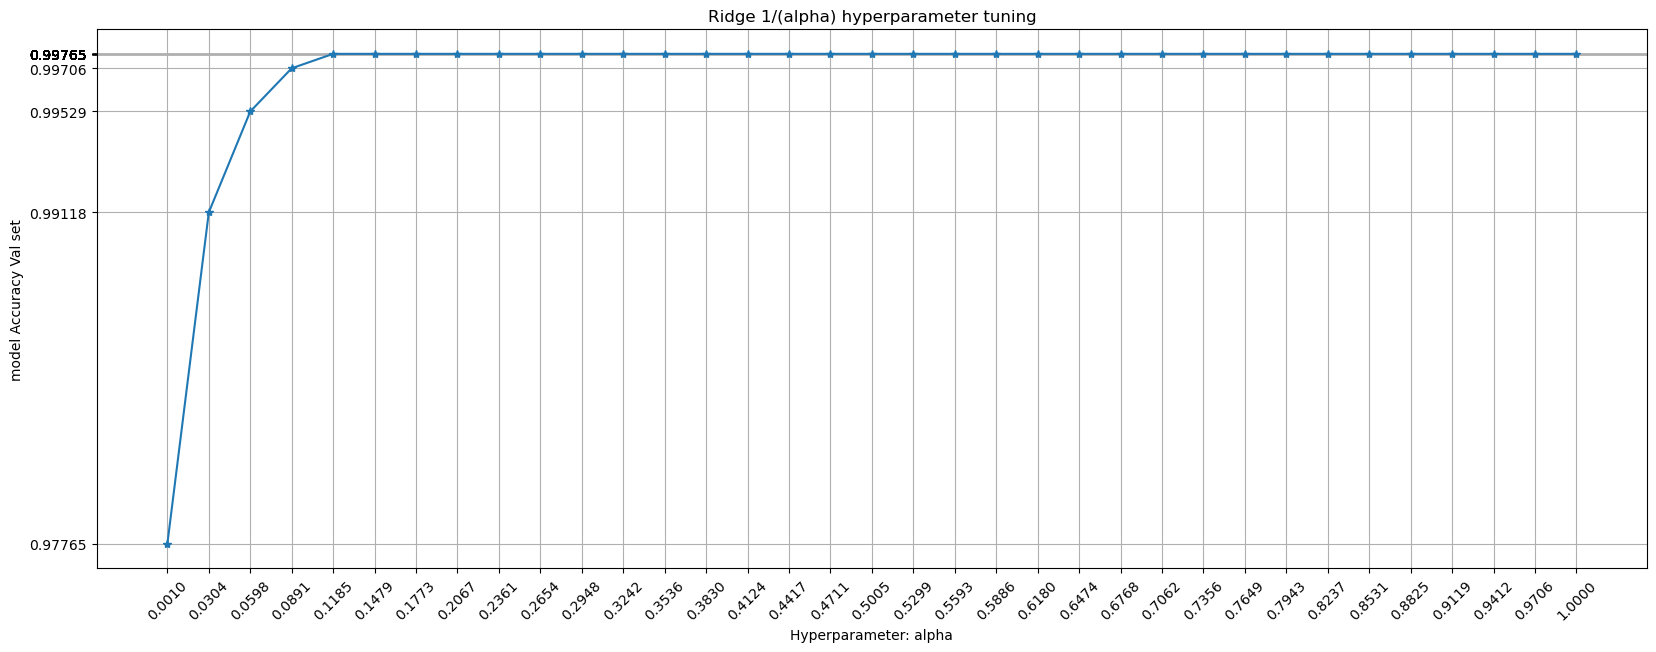

In [263]:
plt.figure(figsize = (20,7))
plt.plot(list_l1_ratio, list_accuracy,marker = '*')
plt.xticks(list_l1_ratio, rotation = 45)
plt.yticks(list_accuracy)
plt.xlabel('Hyperparameter: alpha')
plt.ylabel('model Accuracy Val set')
plt.grid()
plt.title("Ridge 1/(alpha) hyperparameter tuning")
plt.show()

In [264]:
## let's begin making models: logistic regression

## logistic regression model with entire standardized training data

logistic_lasso = LogisticRegression(penalty='l2', C = 1/ 0.1185,  solver = 'liblinear')
# fit on the entire training set  
logistic_lasso.fit(X_full_train, y_full_train)
# predict on test set
yhat_logistic_lasso = logistic_lasso.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_true=y_test, y_pred = yhat_logistic_lasso)
print('Accuracy: %.2f' % (accuracy*100))
print(confusion_matrix(y_true= y_test, y_pred = yhat_logistic_lasso))

Accuracy: 99.93
[[1221    1]
 [   0  278]]


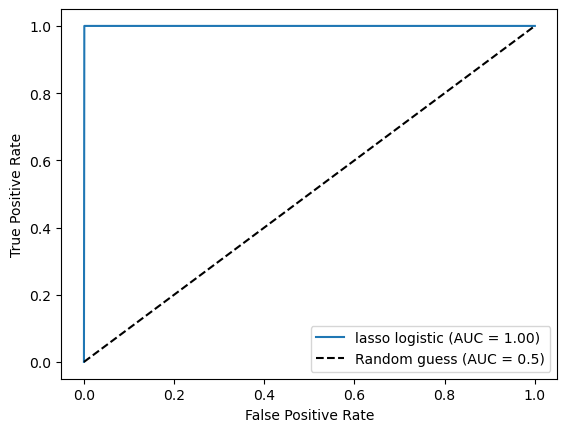

In [265]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat_logistic_lasso)

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name ='lasso logistic')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="Random guess (AUC = 0.5)")
plt.legend()
plt.show()

In [266]:
## variable importance with logisttic regression.

logistic_fi = permutation_importance(logistic, X_test, y_test)
logistic_fi_df = pd.DataFrame({'features' :features.columns, 'importance': logistic_fi['importances_mean']}).set_index('features').sort_values('importance')
logistic_fi_df

,importance
features,
loan_amt_outstanding,0.001200
fico_score,0.007333
income,0.021067
years_employed,0.025600
total_debt_outstanding,0.054133
credit_lines_outstanding,0.228000


<Axes: title={'center': 'Logistic Feature Importances'}, ylabel='features'>

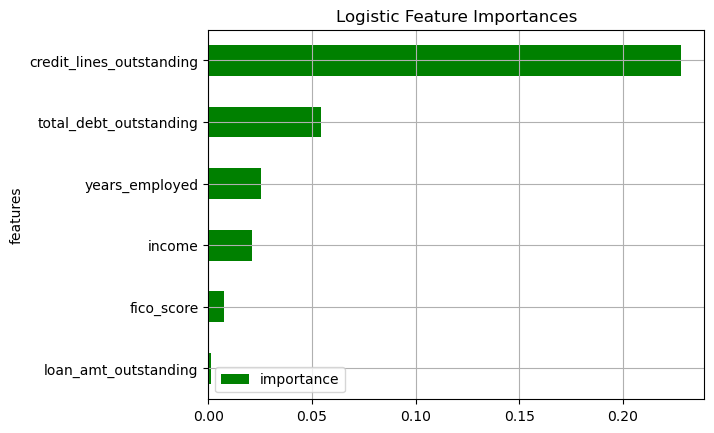

In [267]:
logistic_fi_df.plot(kind = 'barh', title = 'Logistic Feature Importances', grid = True, color='green', align='center')

## Experimenting with Random Forest.

In [268]:
from sklearn.ensemble import RandomForestClassifier
# define the model: using loss criteria ginni
RF = RandomForestClassifier(n_estimators = 10, random_state = 2027)
# fit on the training set
RF.fit(X_full_train,y_full_train)
# predict on test set
yhat_RF = RF.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat_RF)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 99.47


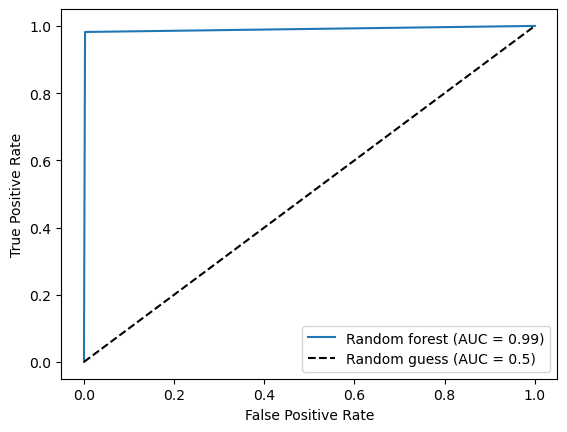

In [269]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,yhat_RF)

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name ='Random forest')
display.plot()
plt.plot([0, 1], [0, 1], "k--", label="Random guess (AUC = 0.5)")
plt.legend()
plt.show()

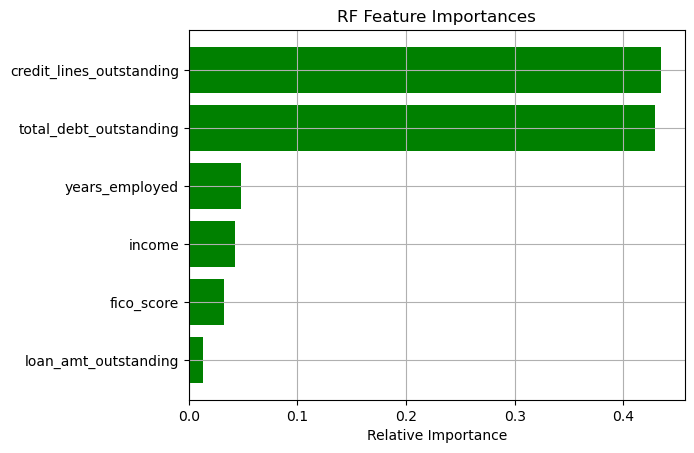

In [270]:
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.title('RF Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.grid()
plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Most important feature obviously is credit_lines_outstanding as explored during EDA
## Logistic regression and RF agree with the importance of features.

## choosing logistic regression for its ease of implimentation, speed and less complexity with very similar performance to a rather complex method


In [271]:
## Creating a forecasting function

def get_expected_loss(arr, intercept_logistic = logistic.intercept_[0],logistic_coef_ =logistic.coef_ ,means = credit.loc[ID_full_train,['loan_amt_outstanding' , 'fico_score', 'total_debt_outstanding', 'income']].mean().values, std = credit.loc[ID_full_train,['loan_amt_outstanding' , 'fico_score', 'total_debt_outstanding', 'income']].std().values):
    ''' Parameters
                    arr: row of observaton as in the given data (SAME ORDER)
                    intercept_logistic: intercept for the logistic model
                    logistic_coef: coefficients for the logistic model ordered in the same way as the arr
                    means: insample or historic means of continous variables ordered 
                    stds: insample or historic standard deviations of continous variables ordered
                    
        returns: expected loss on  a given loan rounded upto 3 decimal places in dollars
    '''
    
    
    ## preprocessing continous variables by standardization
    loan_amt_outstanding = (arr[0] - means[0])/std[0]
    fico_score = (arr[1] - means[1]) / std[1]
    total_debt_outstanding = (arr[2] - means[2])/std[2]
    income = (arr[3] -  means[3])/ std[3]
    years_employed = arr[4]
    credit_lines_outstanding = arr[5]
    normalised_arr = [loan_amt_outstanding, fico_score, total_debt_outstanding, income, years_employed,credit_lines_outstanding]  
    
    log_oddds = intercept_logistic + np.sum(logistic_coef_* normalised_arr) # loan_amt_outstanding * 5.47652901 + fico_score * -(19.18971906) + total_debt_outstanding* 65.50970608 -income*45.58294699 - arr[4] * 30.32485123 + arr[5] *78.16200181
    
    prob_default = 1 / (1+ np.exp(-log_oddds))
    
    expected_loss = prob_default* 0.9*arr[0] ## prob of default * amount lost (90% of the loan amount)
    return round(expected_loss, 3)

In [272]:
estimated_loss = [get_expected_loss(X_test_unscaled[k]) for k in range(len(X_test_unscaled))]
estimated_loss[:20]

[0.0,
 0.0,
 0.0,
 4143.953,
 0.0,
 3283.676,
 5508.754,
 0.0,
 0.0,
 3070.725,
 5172.597,
 0.0,
 0.0,
 0.0,
 4052.15,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## end of notebook